In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from sklearn import preprocessing

In [2]:
NBINS = 60
NE = 100000  # number of events per parametric
NP = 10000   # number of different parametrics

In [3]:
def inverse_sample_decorator(dist):
    def wrapper(pnts, x_min=-100, x_max=100, nbins=NBINS, n=1e5, **kwargs):
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        r_x = x * (13**0.5)
        #print(x.min(),x.max())
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
        cumulative = scaler.fit_transform(cumulative.reshape(-1, 1))
        cumulative = cumulative.reshape(int(n))
        #plt.scatter(r_x, cumulative, label="CDF")
        cdf = interp1d(r_x, cumulative)
        bins = np.linspace(1,7,nbins+1)
        #print(bins)
        cdf_bins = cdf(bins)[1:] - cdf(bins)[:-1]
        #plt.scatter(cumulative, r_x, label="iCDF")
        #plt.legend()
        #plt.show()
        real_low = (cumulative).min()
        real_high = (cumulative).max()
        #print((cumulative/cumulative.max()).max(),(cumulative/cumulative.max()).min())
        ff = interp1d(cumulative, x)
        return ff(np.random.uniform(low=real_low, high=real_high, size=pnts)), cdf_bins 
    return wrapper

In [4]:
# First trying sampling from a simple gaussian distribution
@inverse_sample_decorator
def gauss(x, amp=1.0, mean=0.0, std=0.2):
    return amp*np.exp(-(x-mean)**2/std**2/2.0)

In [5]:
# Experimenting with Eq2
@inverse_sample_decorator
def f(x,ts=[1.1,1.2,1.3,1.4],nbins=60):
    xx = x/(13)**0.5
    v = ts[0] * ((1-xx)**(ts[1])) * (xx**ts[2]) * (xx**(ts[3]*np.log(xx)))
    return v

In [6]:
def data_gen(pmin, pmax, na, nb, f, nbins=60, scaled=False, signal=False):
    init = True
    for i in range(nb):
        samples, y = f(na,ts=np.random.uniform(low=pmin,high=pmax,size=4), nbins=60,
                                            x_min=1/(13**0.5),x_max=7/(13**0.5))
        samples *= (13**0.5)
        
        if signal:
            print(samples.shape)
            sig_samples, _ = gauss(na//100, mean=3.5, std=0.5)
            print(sig_samples.shape)
            samples = np.concatenate((samples, sig_samples))
            print(samples.shape)
        
        plt.style.use("dark_background")
        
        
        n, bins = np.histogram(samples, bins=nbins)
            
        if scaled:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
            n = scaler.fit_transform(n.reshape(-1, 1))
            n = n.reshape(nbins)
            
        if init:
            X = np.array(n)
            Y = np.array(y)
            binsc = 0.5*(bins[1:] + bins[:-1]) 
            init = False

        else:
            X = np.vstack((X,n))
            Y = np.vstack((Y,y))
            
    plt.show()
    return X,Y,binsc

In [7]:
GEN = False
import h5py
if GEN:
    X,Y,binsc= data_gen(1.2,1.8,100000,10000,f,scaled=True)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    Y = Y.reshape(Y.shape[0], Y.shape[1], 1)

    hf = h5py.File("bg-parametric.h5","w")
    hf.create_dataset("sample", data=X)
    hf.create_dataset("bin prob", data=Y)
    hf.close()
else:
    hf = h5py.File("bg-parametric.h5","r")
    X = np.array(hf.get("sample"))
    Y = np.array(hf.get("bin prob"))
    
    bins = np.linspace(1,7,NBINS+1)
    binsc = 0.5*(bins[1:] + bins[:-1]) 
    
print(X.shape, Y.shape)

(10000, 60, 1) (10000, 60, 1)


In [8]:
def prob2event(x):
    x = np.array(x)
    x.reshape(NBINS)
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    x = (x * NE) 
    x = scaler.fit_transform(x.reshape(-1,1))
    x = x.reshape(NBINS)
    return x

In [9]:
def plot1(X, Y):
    plt.style.use("dark_background")
    plt.grid()
    plt.yscale("log")
    plt.ylim((10**-4,10**0))
    plt.xlabel("m[TeV]")
    plt.ylabel("Events per bin")
    plt.scatter(binsc,X, s=6, label="sample", c="cyan")
    plt.scatter(binsc,prob2event(Y), s=6, label="bin prob", c="orange")
    plt.legend()
    plt.show()

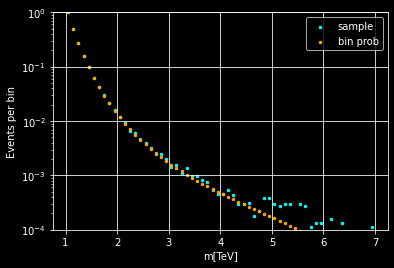

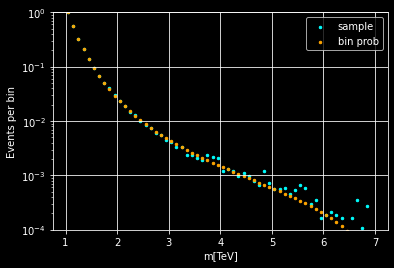

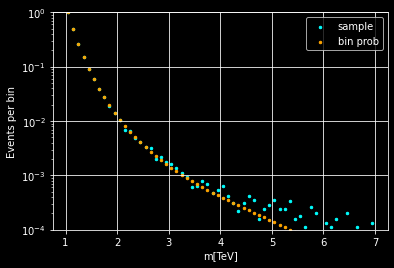

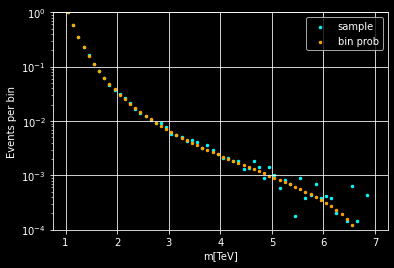

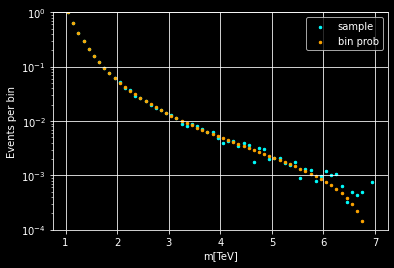

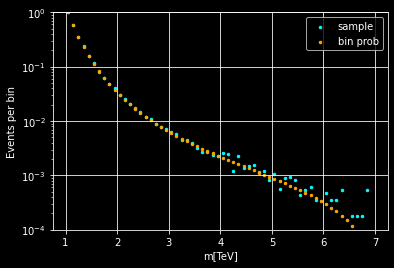

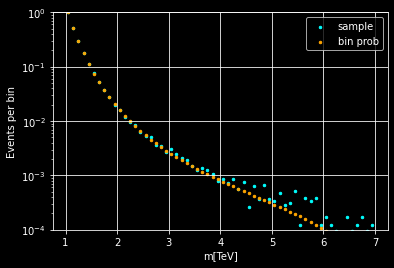

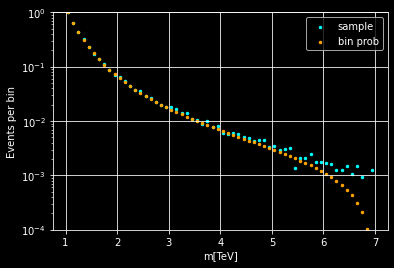

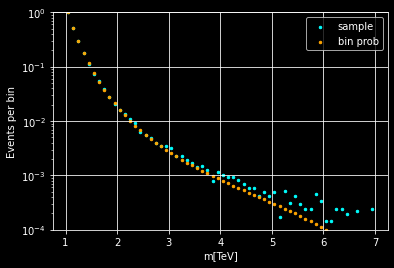

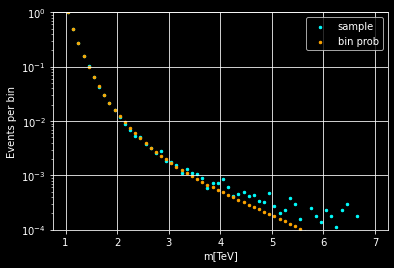

In [10]:
for i in np.random.randint(NP, size=10):
    plot1(X[i,:], Y[i,:])

In [11]:
import tensorflow.keras as keras
import tensorflow as tf

In [12]:
Y_shifted = np.roll(Y,1)

In [13]:
def create_s2s(latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None, 1))
    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = keras.Input(shape=(None, 1))

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(1, activation="linear")
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

In [14]:
def train_model(sample_weight, modeln, TRAIN=True, PLOSS=True, verbose=1):
    
    print("    Training {}...".format(modeln))
    
    info = [int(i) for i in modeln.split("_")[1:-2]]
    latent_dim, batch_size, patience, epochs = info
    print("    latent_dim={}".format(latent_dim))
    print("    batch_size={}".format(batch_size))
    print("    patience={}".format(patience))
    print("    epochs={}".format(epochs))
    
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                               patience=patience, verbose=0,
                                               mode='auto', baseline=None,
                                               restore_best_weights=True)]


    if TRAIN:
        model = create_s2s(latent_dim)
        model.compile(optimizer="adam", loss="mse")
        history = model.fit(
            [X, Y_shifted],
            Y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            verbose=verbose,
            callbacks=callbacks,
            sample_weight=sample_weight)
        if PLOSS:
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('Loss')
            plt.yscale("log")
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['train', 'val'], loc='upper right')
            plt.show()

    model.save(modeln)

In [15]:
def create_decode(modeln, TRAIN=True):
    # Define sampling models
    # Restore the model and construct the encoder and decoder.
    if TRAIN:
        model = keras.models.load_model(modeln)
    else:  
        model = keras.models.load_model("s2s_256_stable")

    latent_dim = int(modeln.split("_")[1])
    print(latent_dim)
    encoder_inputs = model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    decoder_inputs = model.input[1]  # input_2
    decoder_state_input_h = keras.Input(shape=(latent_dim,))
    decoder_state_input_c = keras.Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.layers[3]
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h_dec, state_c_dec]
    decoder_dense = model.layers[4]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = keras.Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )
    
    return encoder_model, decoder_model

In [16]:
def decode_sequence(input_seq, encoder_model, decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 0.5

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_dist = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_char = output_tokens[0,0,0]
        #print(sampled_char)
        decoded_dist.append(sampled_char)

        # Exit condition: either hit max length
        if len(decoded_dist) == 60:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = sampled_char

        # Update states
        states_value = [h, c]
    return decoded_dist

In [17]:
def test1(lowp, highp, modeln, ne=NE, plot=True, signal=False):
    print("    Testing {}...".format(modeln))
    X_test,Y_test,binsc= data_gen(lowp,highp,ne,1,f,scaled=True,signal=signal)
    X_test = X_test.reshape(1, X_test.shape[0], 1)
    Y_test = Y_test.reshape(1, Y_test.shape[0], 1)

    encoder_model, decoder_model = create_decode(modeln)
    Y_hat = decode_sequence(X_test, encoder_model, decoder_model)
    mse = np.sum((Y_hat - Y_test)**2)
    print("    Test MSE: {}".format(mse))
    print("    Test Sum: {}".format(sum(Y_hat)))
    

    if plot:
        plt.grid()
        plt.ylim((10**-4,10**0))
        plt.yscale("log")
        plt.scatter(binsc,X_test, s=6, label="sample",c="cyan")
        plt.scatter(binsc, prob2event(Y_test), s=6, label="true bin prob", c="orange")
        plt.scatter(binsc, prob2event(Y_hat), s=6, label="predict bin prob ({:.2f})".format(mse), c="red")
        plt.xlabel("m[TeV]")
        plt.ylabel("Events per bin")
        plt.title("Test on parametric ({},{})".format(lowp, highp))
        if signal:
            plt.title("Test on parametric ({},{}) with injected signal".format(lowp, highp))
            plt.axvline(x=3.5, alpha=0.6, linestyle="--", c='r')
        plt.legend()
        plt.show()
    return X_test, Y_test, Y_hat

In [18]:
def train_test(sample_weight, latent_dim=256, batch_size=64, patience=25, epochs=100, test_num=10, verbose=1):
    
    modeln = "s2s_{}_{}_{}_{}_{:2f}_exp".format(latent_dim, batch_size, patience, epochs, 
                                                float(sum(sample_weight[0][0])))
    
    print("Curr model: {}".format(modeln))
    
    train_model(sample_weight, modeln, TRAIN=True, verbose=verbose)
    
    for i in range(test_num):
        test1(1.2, 1.8, modeln)

In [19]:
# xx = np.linspace(1,4,60)
# sample_weight = np.exp(-xx)[::-1]
# sample_weight = np.repeat(sample_weight, repeats=X.shape[0]).reshape(X.shape)
# train_test(sample_weight, latent_dim=256, batch_size=64, patience=25, epochs=100, test_num=10)

In [20]:
# ii = 1
# while ii <= 20:
#     print(ii)
#     xx = np.linspace(1,ii,60)
#     sample_weight = np.exp(-xx)[::-1]
#     sample_weight = np.repeat(sample_weight, repeats=X.shape[0]).reshape(X.shape)
#     train_test(sample_weight, latent_dim=256, batch_size=64, patience=15, epochs=100, test_num=10)
#     ii += 0.1

In [21]:
X_test,Y_test,binsc= data_gen(1.2,1.8,NE,1,f,scaled=True,signal=False)
print(X_test.shape, Y_test.shape)

(60,) (60,)


In [22]:
sample_weight = X_test[::-1]
sample_weight = np.repeat(sample_weight, repeats=X.shape[0]).reshape(X.shape)

Curr model: s2s_32_64_450_500_0.000000_exp
    Training s2s_32_64_450_500_0.000000_exp...
    latent_dim=32
    batch_size=64
    patience=450
    epochs=500


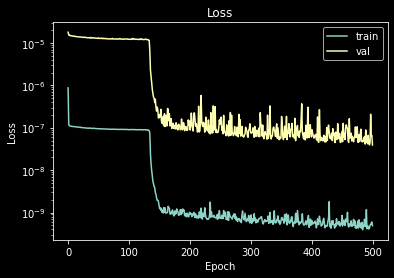

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: s2s_32_64_450_500_0.000000_exp/assets
    Testing s2s_32_64_450_500_0.000000_exp...
32
    Test MSE: 15.363167726569507
    Test Sum: 1.050938330590725


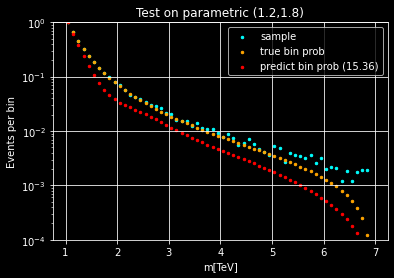

    Testing s2s_32_64_450_500_0.000000_exp...
32
    Test MSE: 26.45007617592712
    Test Sum: 1.0695060603320599


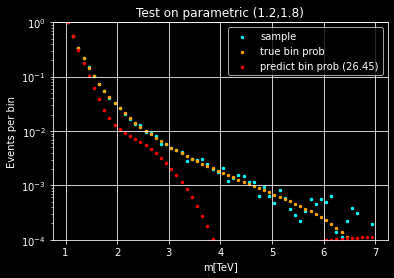

    Testing s2s_32_64_450_500_0.000000_exp...
32
    Test MSE: 27.366696462180435
    Test Sum: 1.0663229525089264


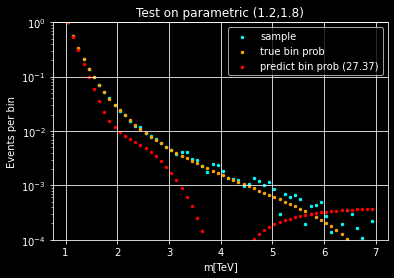

    Testing s2s_32_64_450_500_0.000000_exp...
32
    Test MSE: 21.457642357210936
    Test Sum: 1.0745361670851707


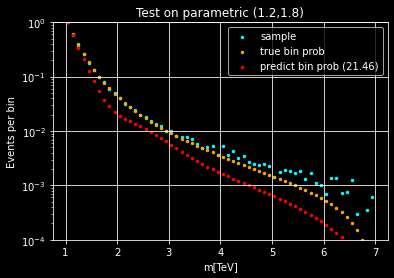

    Testing s2s_32_64_450_500_0.000000_exp...
32
    Test MSE: 21.880819170274176
    Test Sum: 1.074368704110384


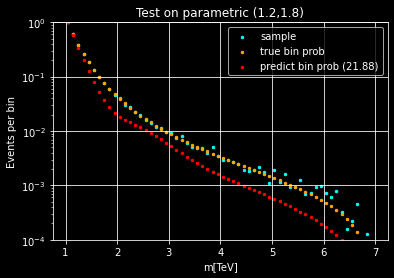

    Testing s2s_32_64_450_500_0.000000_exp...
32
    Test MSE: 32.03894509574533
    Test Sum: 1.0454646460711956


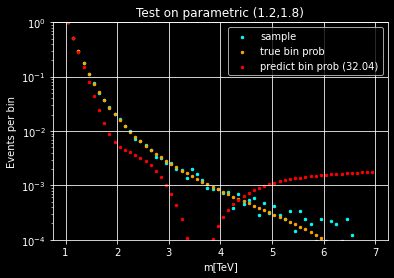

    Testing s2s_32_64_450_500_0.000000_exp...
32
    Test MSE: 27.852590145608175
    Test Sum: 1.0655248053371906


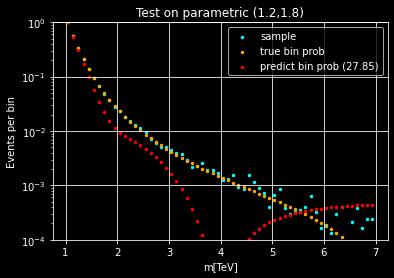

    Testing s2s_32_64_450_500_0.000000_exp...
32
    Test MSE: 22.285796041355454
    Test Sum: 1.074644597247243


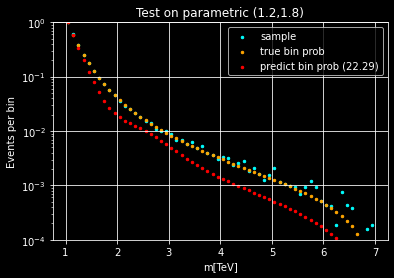

    Testing s2s_32_64_450_500_0.000000_exp...
32
    Test MSE: 24.71882649670537
    Test Sum: 1.0735069904476404


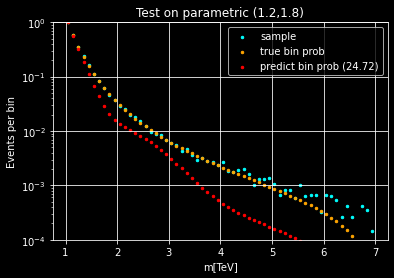

    Testing s2s_32_64_450_500_0.000000_exp...
32
    Test MSE: 30.6618952602309
    Test Sum: 1.0520297177135944


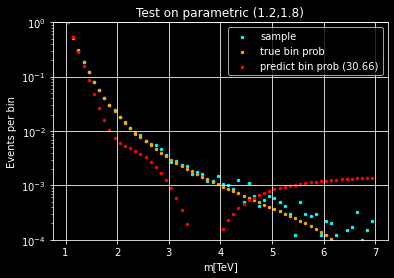

Curr model: s2s_64_64_450_500_0.000000_exp
    Training s2s_64_64_450_500_0.000000_exp...
    latent_dim=64
    batch_size=64
    patience=450
    epochs=500


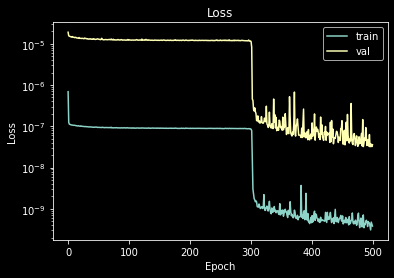

INFO:tensorflow:Assets written to: s2s_64_64_450_500_0.000000_exp/assets
    Testing s2s_64_64_450_500_0.000000_exp...
64
    Test MSE: 33.46989949093898
    Test Sum: 1.006061589345336


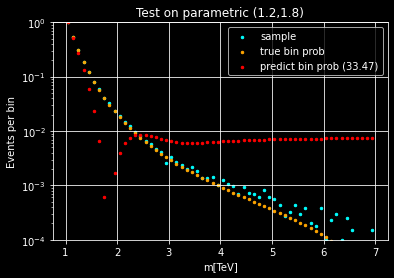

    Testing s2s_64_64_450_500_0.000000_exp...
64
    Test MSE: 29.691605352332722
    Test Sum: 1.01144340634346


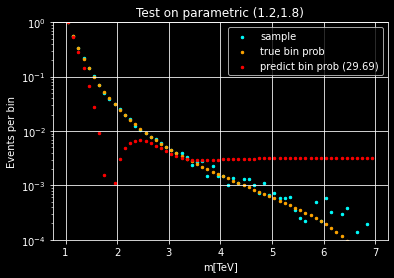

    Testing s2s_64_64_450_500_0.000000_exp...
64
    Test MSE: 30.366474551186002
    Test Sum: 1.0104212947189808


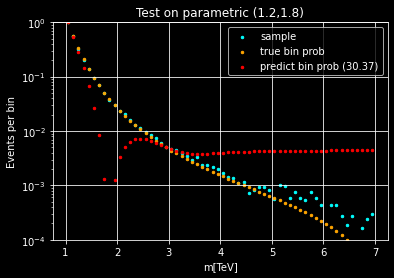

    Testing s2s_64_64_450_500_0.000000_exp...
64
    Test MSE: 34.40095382606495
    Test Sum: 1.0042163711041212


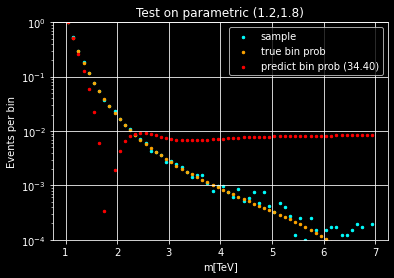

    Testing s2s_64_64_450_500_0.000000_exp...
64
    Test MSE: 29.37309701480818
    Test Sum: 1.0116797611117363


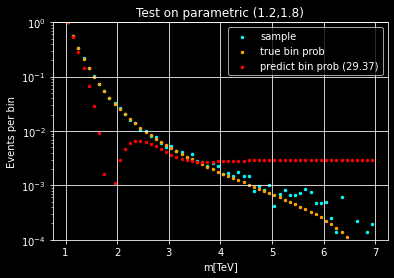

    Testing s2s_64_64_450_500_0.000000_exp...
64
    Test MSE: 33.46537646642905
    Test Sum: 1.0059278886765242


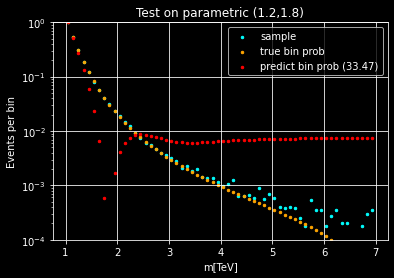

    Testing s2s_64_64_450_500_0.000000_exp...
64
    Test MSE: 19.28081861067813
    Test Sum: 0.9976545982062817


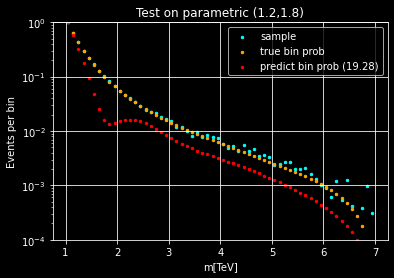

    Testing s2s_64_64_450_500_0.000000_exp...
64
    Test MSE: 35.867642103212276
    Test Sum: 1.0011561177670956


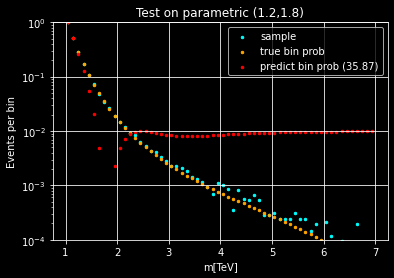

    Testing s2s_64_64_450_500_0.000000_exp...
64
    Test MSE: 28.148293101977483
    Test Sum: 1.0123240575194359


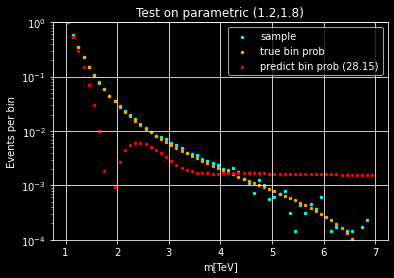

    Testing s2s_64_64_450_500_0.000000_exp...
64
    Test MSE: 27.928900225807876
    Test Sum: 1.0124036855995655


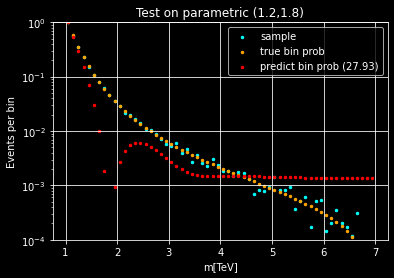

Curr model: s2s_256_64_450_500_0.000000_exp
    Training s2s_256_64_450_500_0.000000_exp...
    latent_dim=256
    batch_size=64
    patience=450
    epochs=500


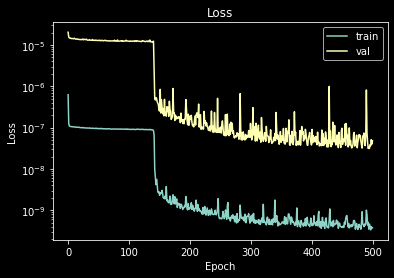

INFO:tensorflow:Assets written to: s2s_256_64_450_500_0.000000_exp/assets
    Testing s2s_256_64_450_500_0.000000_exp...
256
    Test MSE: 26.243008906659412
    Test Sum: 1.1813524384051561


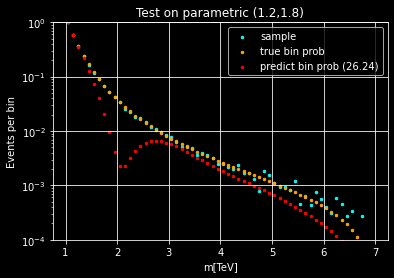

    Testing s2s_256_64_450_500_0.000000_exp...
256
    Test MSE: 22.679590954202002
    Test Sum: 1.173744808882475


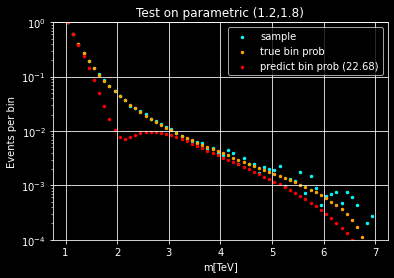

    Testing s2s_256_64_450_500_0.000000_exp...
256
    Test MSE: 29.21646959668125
    Test Sum: 1.1811544466763735


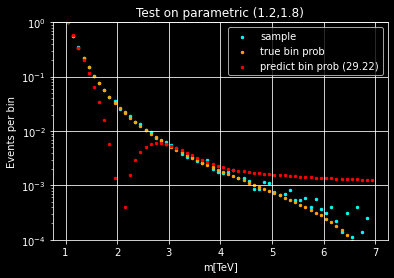

    Testing s2s_256_64_450_500_0.000000_exp...
256
    Test MSE: 30.31832368963447
    Test Sum: 1.1799731366336346


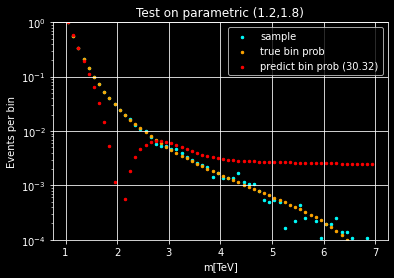

    Testing s2s_256_64_450_500_0.000000_exp...
256
    Test MSE: 36.44775393338217
    Test Sum: 1.1667881198227406


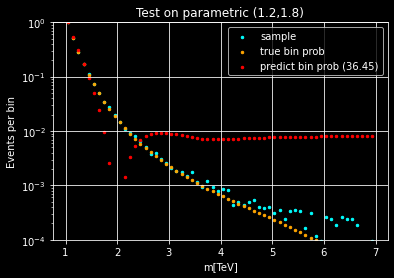

    Testing s2s_256_64_450_500_0.000000_exp...
256
    Test MSE: 22.08650892437337
    Test Sum: 1.17108410038054


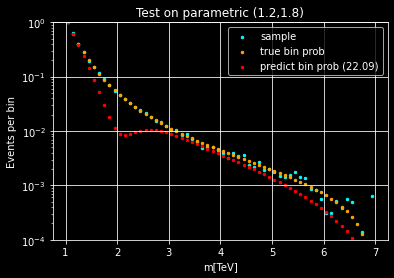

    Testing s2s_256_64_450_500_0.000000_exp...
256
    Test MSE: 27.93399814910007
    Test Sum: 1.1818085480481386


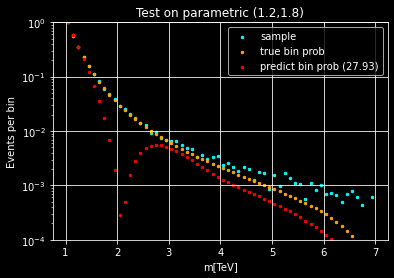

    Testing s2s_256_64_450_500_0.000000_exp...
256
    Test MSE: 32.77175412767896
    Test Sum: 1.1761459335684776


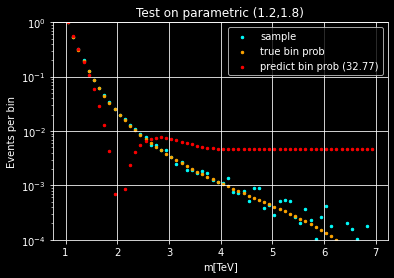

    Testing s2s_256_64_450_500_0.000000_exp...
256
    Test MSE: 27.54935529950922
    Test Sum: 1.1818126030266285


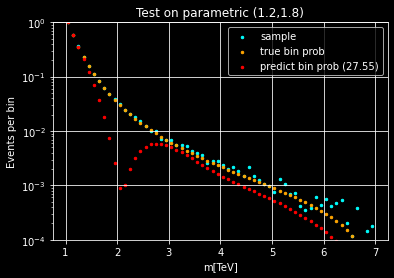

    Testing s2s_256_64_450_500_0.000000_exp...
256
    Test MSE: 21.651578909006602
    Test Sum: 1.170064751058817


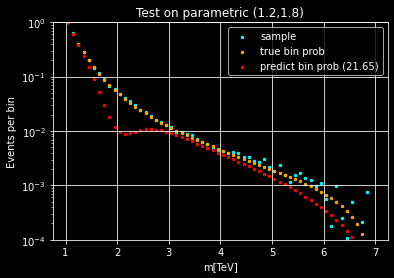

Curr model: s2s_400_64_450_500_0.000000_exp
    Training s2s_400_64_450_500_0.000000_exp...
    latent_dim=400
    batch_size=64
    patience=450
    epochs=500


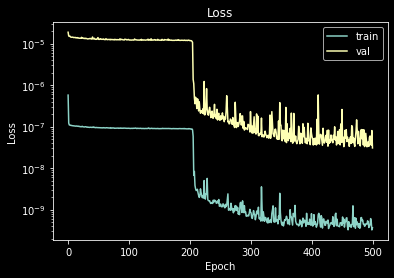

INFO:tensorflow:Assets written to: s2s_400_64_450_500_0.000000_exp/assets
    Testing s2s_400_64_450_500_0.000000_exp...
400
    Test MSE: 22.947559433029305
    Test Sum: 1.1348449308425188


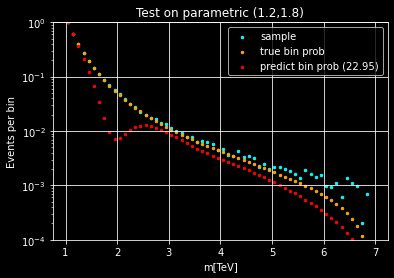

    Testing s2s_400_64_450_500_0.000000_exp...
400
    Test MSE: 29.696607906850293
    Test Sum: 1.1395896468311548


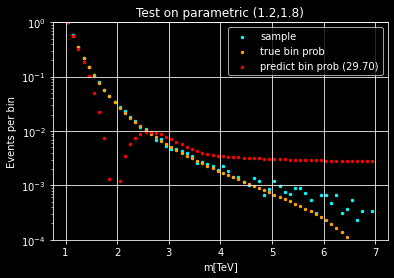

    Testing s2s_400_64_450_500_0.000000_exp...
400
    Test MSE: 16.240145122095264
    Test Sum: 1.0998728182166815


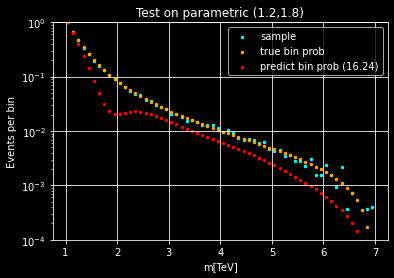

    Testing s2s_400_64_450_500_0.000000_exp...
400
    Test MSE: 35.17945379955051
    Test Sum: 1.1268375869840384


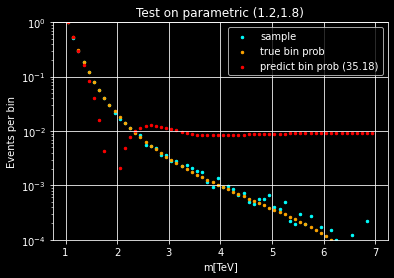

    Testing s2s_400_64_450_500_0.000000_exp...
400
    Test MSE: 37.16531096894443
    Test Sum: 1.1219164803624153


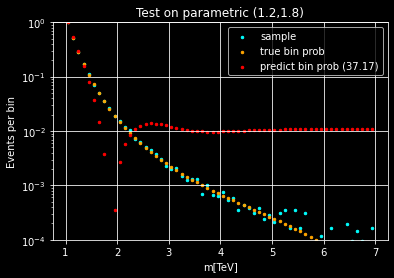

    Testing s2s_400_64_450_500_0.000000_exp...
400
    Test MSE: 40.43026475146367
    Test Sum: 1.111436765640974


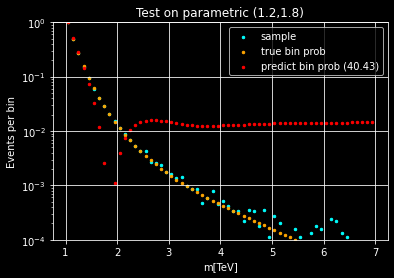

    Testing s2s_400_64_450_500_0.000000_exp...
400
    Test MSE: 25.6510487471943
    Test Sum: 1.1403049193322659


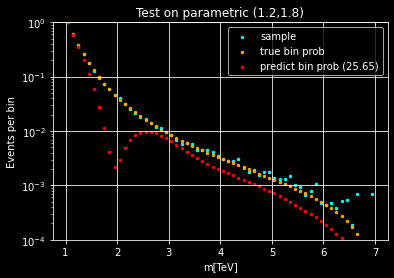

    Testing s2s_400_64_450_500_0.000000_exp...
400
    Test MSE: 24.208094111079404
    Test Sum: 1.1382045205682516


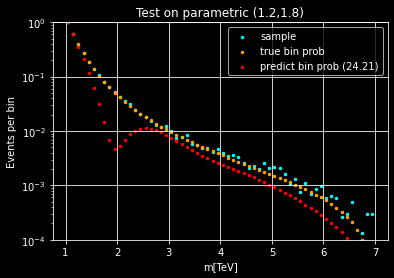

    Testing s2s_400_64_450_500_0.000000_exp...
400
    Test MSE: 32.99139258285437
    Test Sum: 1.1334445867687464


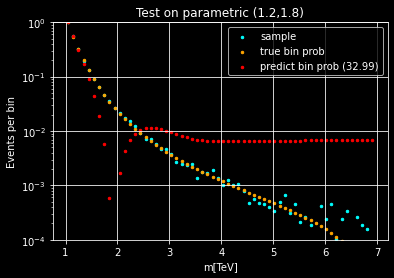

    Testing s2s_400_64_450_500_0.000000_exp...
400
    Test MSE: 31.81455345048522
    Test Sum: 1.1359889563173056


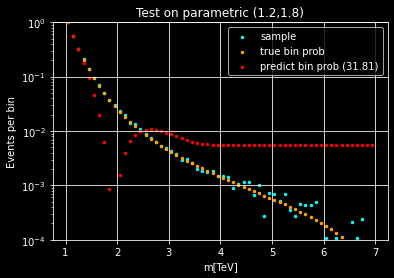

Curr model: s2s_500_64_450_500_0.000000_exp
    Training s2s_500_64_450_500_0.000000_exp...
    latent_dim=500
    batch_size=64
    patience=450
    epochs=500


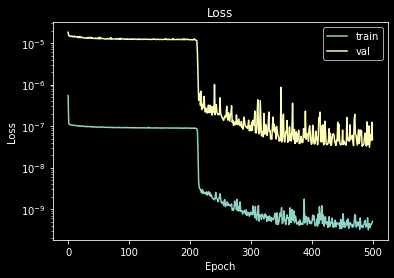

INFO:tensorflow:Assets written to: s2s_500_64_450_500_0.000000_exp/assets
    Testing s2s_500_64_450_500_0.000000_exp...
500
    Test MSE: 39.63468054337182
    Test Sum: 1.0853155553340912


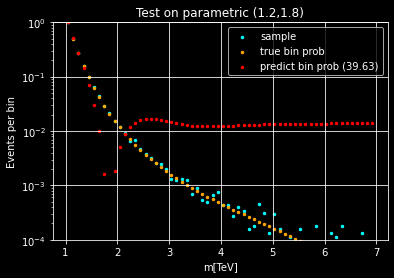

    Testing s2s_500_64_450_500_0.000000_exp...
500
    Test MSE: 36.31164095488599
    Test Sum: 1.0923694763332605


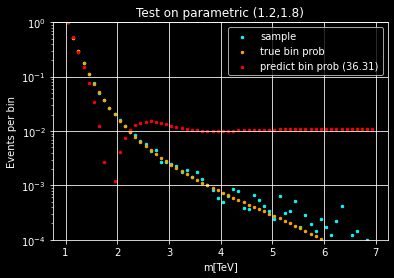

    Testing s2s_500_64_450_500_0.000000_exp...
500
    Test MSE: 30.77998397551862
    Test Sum: 1.1021243464201689


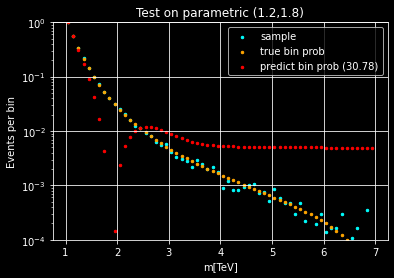

    Testing s2s_500_64_450_500_0.000000_exp...
500
    Test MSE: 32.72720404582928
    Test Sum: 1.099207365885377


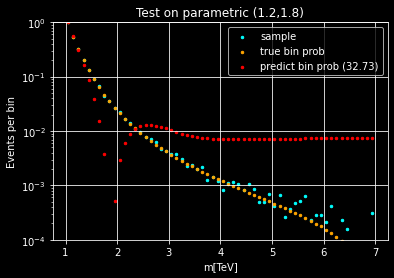

    Testing s2s_500_64_450_500_0.000000_exp...
500
    Test MSE: 19.626892398823784
    Test Sum: 1.0831151269376278


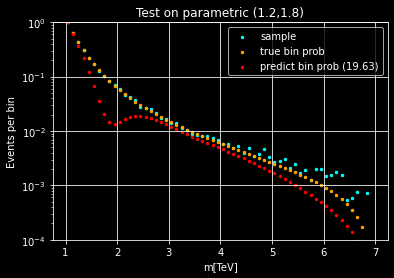

    Testing s2s_500_64_450_500_0.000000_exp...
500
    Test MSE: 39.22278452321875
    Test Sum: 1.0859415605664253


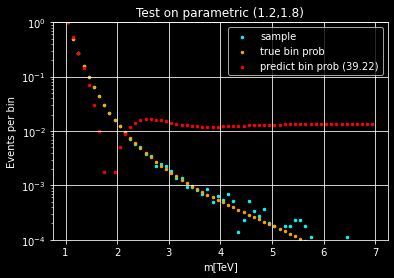

    Testing s2s_500_64_450_500_0.000000_exp...
500
    Test MSE: 36.145989462375056
    Test Sum: 1.092510549351573


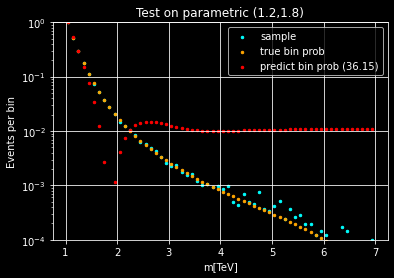

    Testing s2s_500_64_450_500_0.000000_exp...
500
    Test MSE: 29.4908586644042
    Test Sum: 1.103405511006713


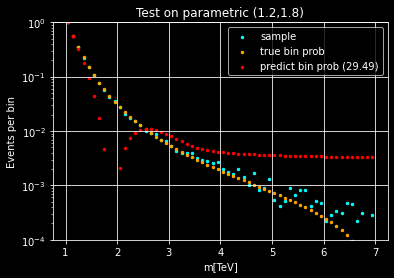

    Testing s2s_500_64_450_500_0.000000_exp...
500
    Test MSE: 16.92341516434115
    Test Sum: 1.0668934844434261


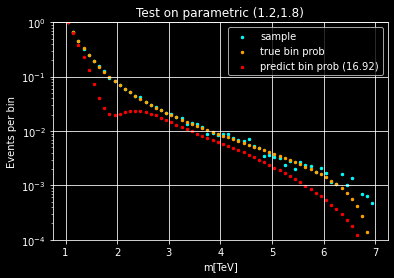

    Testing s2s_500_64_450_500_0.000000_exp...
500
    Test MSE: 25.37760487873151
    Test Sum: 1.1026574615389109


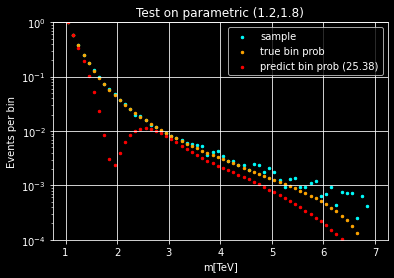

Curr model: s2s_600_64_450_500_0.000000_exp
    Training s2s_600_64_450_500_0.000000_exp...
    latent_dim=600
    batch_size=64
    patience=450
    epochs=500


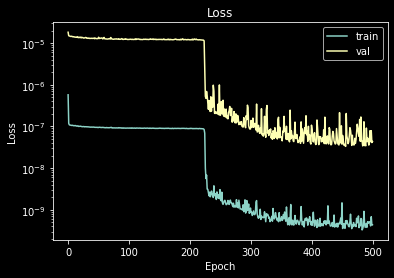

INFO:tensorflow:Assets written to: s2s_600_64_450_500_0.000000_exp/assets
    Testing s2s_600_64_450_500_0.000000_exp...
600
    Test MSE: 20.403219483526318
    Test Sum: 1.1153231244534254


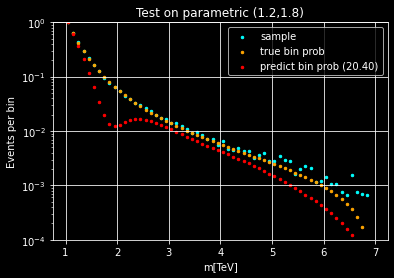

    Testing s2s_600_64_450_500_0.000000_exp...
600
    Test MSE: 35.411255938671154
    Test Sum: 1.1272278614342213


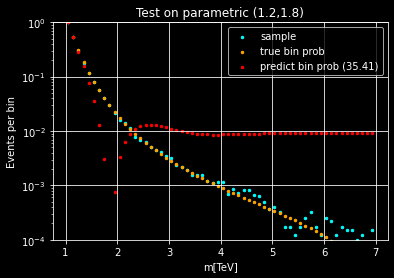

    Testing s2s_600_64_450_500_0.000000_exp...
600
    Test MSE: 35.603948448829364
    Test Sum: 1.1267418842762709


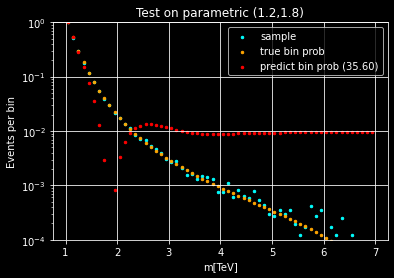

    Testing s2s_600_64_450_500_0.000000_exp...
600
    Test MSE: 20.91173135928687
    Test Sum: 1.1193420644849539


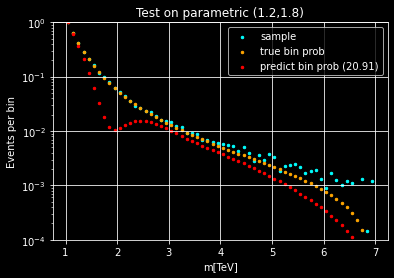

    Testing s2s_600_64_450_500_0.000000_exp...
600
    Test MSE: 38.500213128717746
    Test Sum: 1.12221210449934


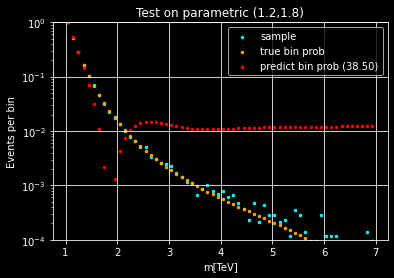

    Testing s2s_600_64_450_500_0.000000_exp...
600
    Test MSE: 24.78486491825201
    Test Sum: 1.131217546761036


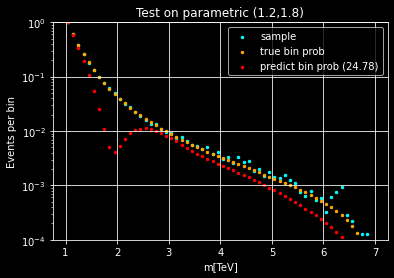

    Testing s2s_600_64_450_500_0.000000_exp...
600
    Test MSE: 26.95521953578625
    Test Sum: 1.13419377990067


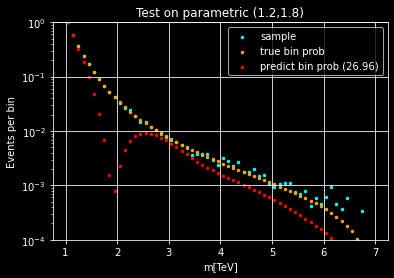

    Testing s2s_600_64_450_500_0.000000_exp...
600
    Test MSE: 34.895925657700815
    Test Sum: 1.1282109189778566


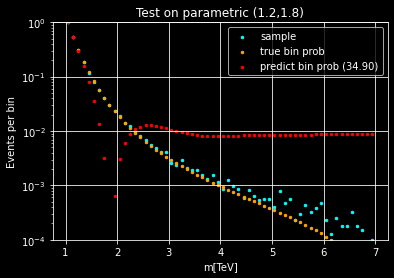

    Testing s2s_600_64_450_500_0.000000_exp...
600
    Test MSE: 23.81069681909279
    Test Sum: 1.1288541685789824


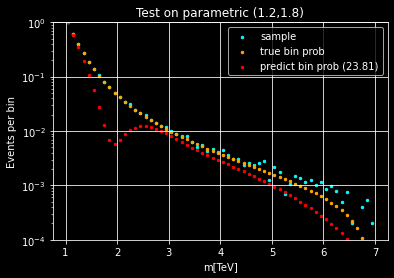

    Testing s2s_600_64_450_500_0.000000_exp...
600
    Test MSE: 38.50603414083756
    Test Sum: 1.1221253387629986


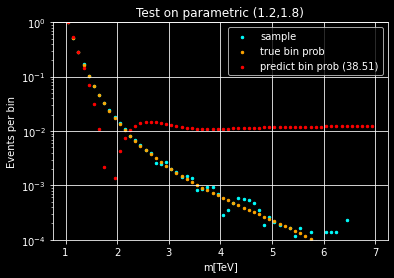

Curr model: s2s_700_64_450_500_0.000000_exp
    Training s2s_700_64_450_500_0.000000_exp...
    latent_dim=700
    batch_size=64
    patience=450
    epochs=500


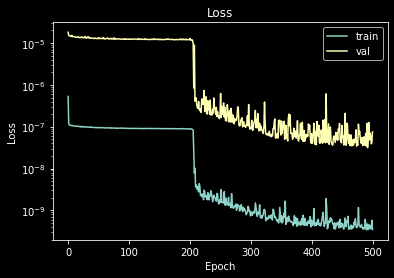

INFO:tensorflow:Assets written to: s2s_700_64_450_500_0.000000_exp/assets
    Testing s2s_700_64_450_500_0.000000_exp...
700
    Test MSE: 39.4970530064809
    Test Sum: 1.124134711921215


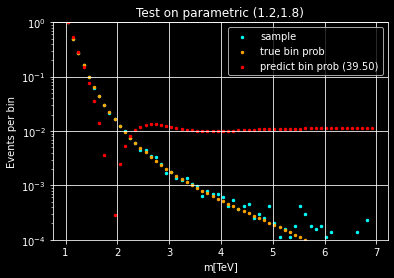

    Testing s2s_700_64_450_500_0.000000_exp...
700
    Test MSE: 36.80307165807866
    Test Sum: 1.1321168448776007


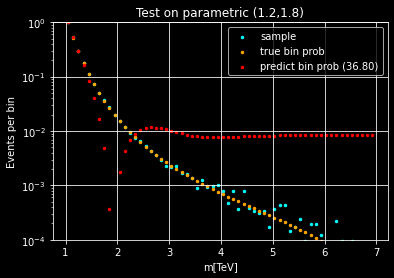

    Testing s2s_700_64_450_500_0.000000_exp...
700
    Test MSE: 29.24818016243193
    Test Sum: 1.1457329913973808


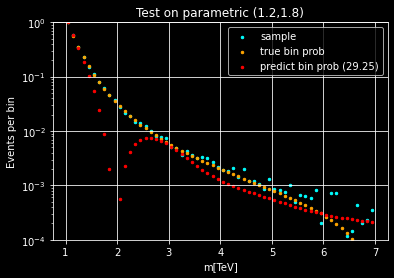

    Testing s2s_700_64_450_500_0.000000_exp...
700
    Test MSE: 23.900777299462398
    Test Sum: 1.140075944364071


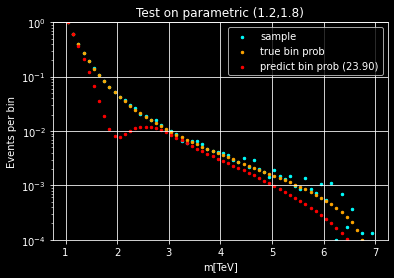

    Testing s2s_700_64_450_500_0.000000_exp...
700
    Test MSE: 38.89488252647132
    Test Sum: 1.1259620431810617


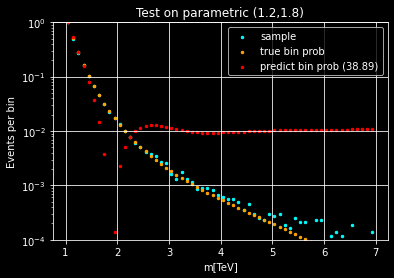

    Testing s2s_700_64_450_500_0.000000_exp...
700
    Test MSE: 35.52809925081275
    Test Sum: 1.135026391595602


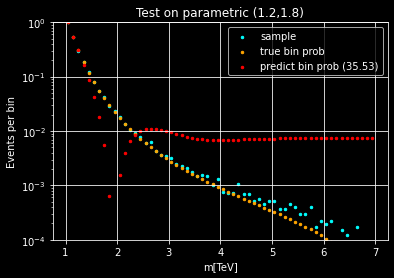

    Testing s2s_700_64_450_500_0.000000_exp...
700
    Test MSE: 24.267570260668617
    Test Sum: 1.1409614384174347


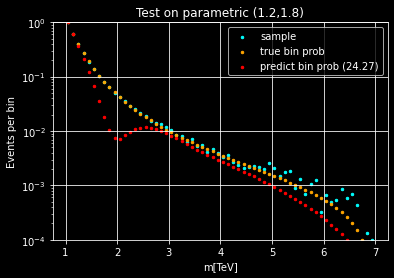

    Testing s2s_700_64_450_500_0.000000_exp...
700
    Test MSE: 37.22888027387205
    Test Sum: 1.1308439802378416


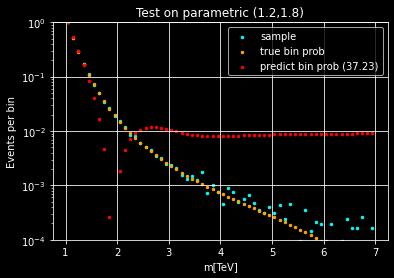

    Testing s2s_700_64_450_500_0.000000_exp...
700
    Test MSE: 29.91683933587456
    Test Sum: 1.1452968530356884


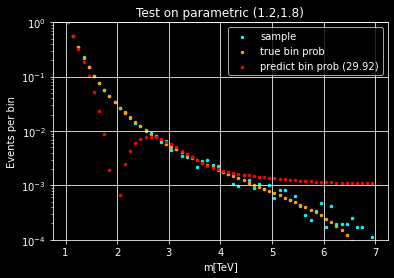

    Testing s2s_700_64_450_500_0.000000_exp...
700
    Test MSE: 29.36663082743071
    Test Sum: 1.1456330120563507


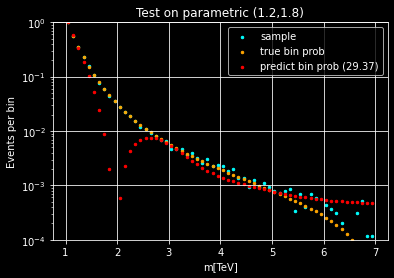

Curr model: s2s_800_64_450_500_0.000000_exp
    Training s2s_800_64_450_500_0.000000_exp...
    latent_dim=800
    batch_size=64
    patience=450
    epochs=500


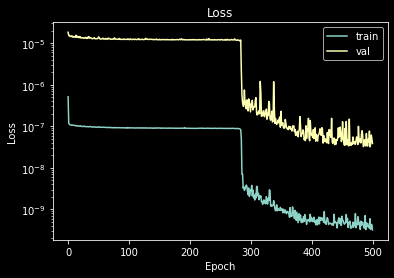

INFO:tensorflow:Assets written to: s2s_800_64_450_500_0.000000_exp/assets
    Testing s2s_800_64_450_500_0.000000_exp...
800
    Test MSE: 34.655008549734234
    Test Sum: 1.0812986493110657


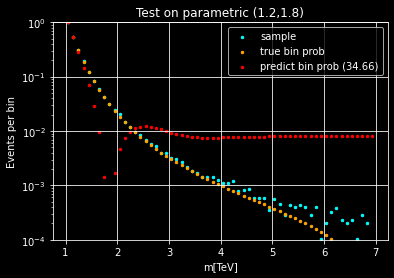

    Testing s2s_800_64_450_500_0.000000_exp...
800
    Test MSE: 21.014668974027128
    Test Sum: 1.073852276429534


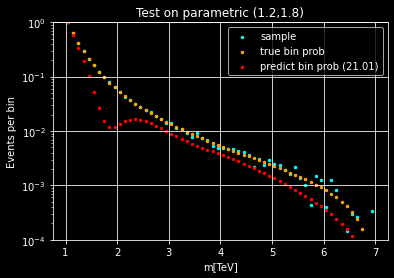

    Testing s2s_800_64_450_500_0.000000_exp...
800
    Test MSE: 24.320884723975972
    Test Sum: 1.0837082229554653


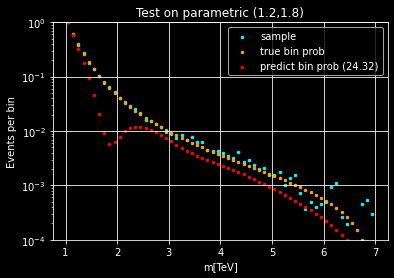

    Testing s2s_800_64_450_500_0.000000_exp...
800
    Test MSE: 34.33716880504358
    Test Sum: 1.0818538293242455


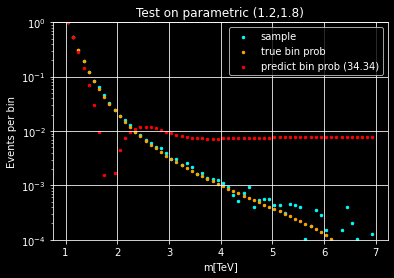

    Testing s2s_800_64_450_500_0.000000_exp...
800
    Test MSE: 27.863658164525035
    Test Sum: 1.087278688326478


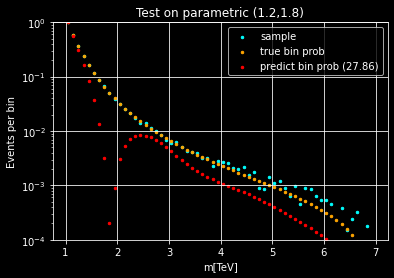

    Testing s2s_800_64_450_500_0.000000_exp...
800
    Test MSE: 39.070607333524464
    Test Sum: 1.0736840032041073


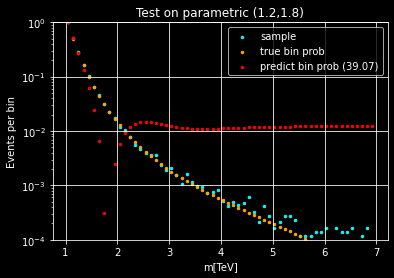

    Testing s2s_800_64_450_500_0.000000_exp...
800
    Test MSE: 37.48328578895278
    Test Sum: 1.0761403180658817


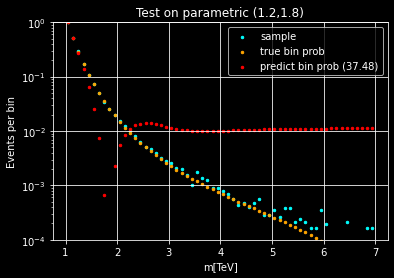

    Testing s2s_800_64_450_500_0.000000_exp...
800
    Test MSE: 26.30309404020814
    Test Sum: 1.0863578356802464


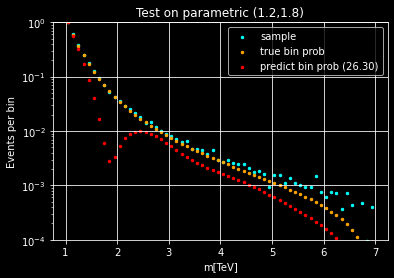

    Testing s2s_800_64_450_500_0.000000_exp...
800
    Test MSE: 23.440131723529003
    Test Sum: 1.0816756580024958


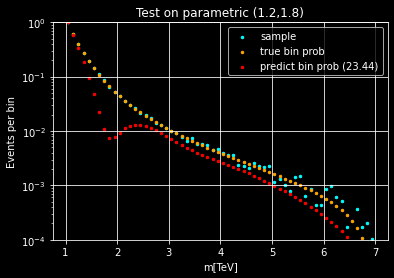

    Testing s2s_800_64_450_500_0.000000_exp...
800
    Test MSE: 17.74616786351997
    Test Sum: 1.0567539855837822


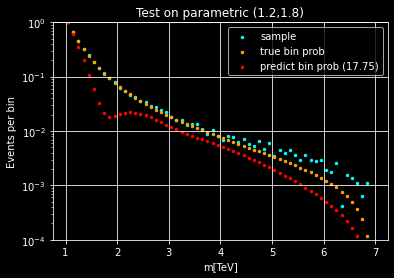

Curr model: s2s_900_64_450_500_0.000000_exp
    Training s2s_900_64_450_500_0.000000_exp...
    latent_dim=900
    batch_size=64
    patience=450
    epochs=500


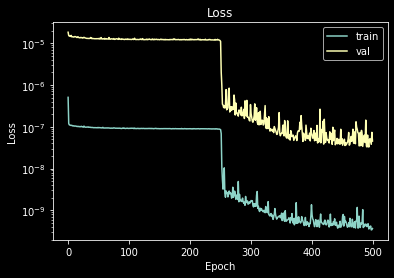

INFO:tensorflow:Assets written to: s2s_900_64_450_500_0.000000_exp/assets
    Testing s2s_900_64_450_500_0.000000_exp...
900
    Test MSE: 38.347549161895294
    Test Sum: 1.0827913992106915


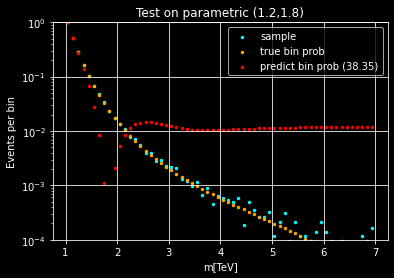

    Testing s2s_900_64_450_500_0.000000_exp...
900
    Test MSE: 22.79773578027161
    Test Sum: 1.0856406558305025


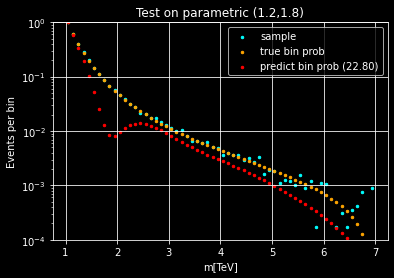

    Testing s2s_900_64_450_500_0.000000_exp...
900
    Test MSE: 27.78738083174936
    Test Sum: 1.0941934194415808


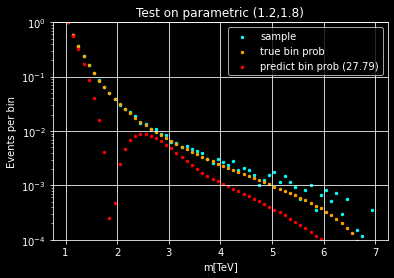

    Testing s2s_900_64_450_500_0.000000_exp...
900
    Test MSE: 31.891956785706462
    Test Sum: 1.0925005301833153


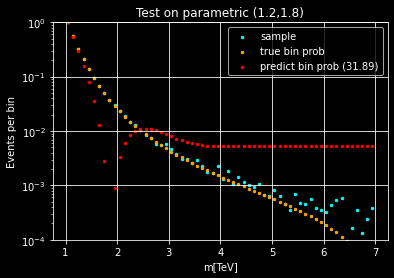

    Testing s2s_900_64_450_500_0.000000_exp...
900
    Test MSE: 27.744911193992447
    Test Sum: 1.0941403321921825


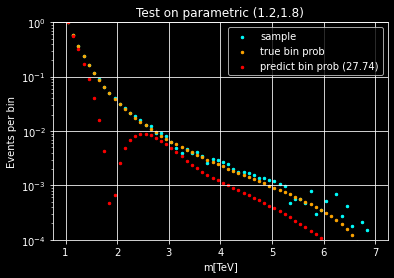

    Testing s2s_900_64_450_500_0.000000_exp...
900
    Test MSE: 26.948348099554714
    Test Sum: 1.0937571823596954


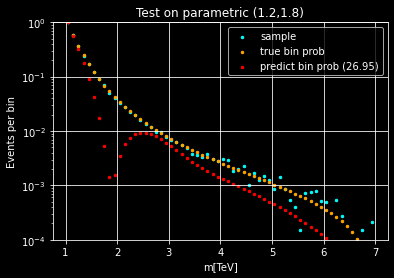

    Testing s2s_900_64_450_500_0.000000_exp...
900
    Test MSE: 28.92659516641632
    Test Sum: 1.0943581592291594


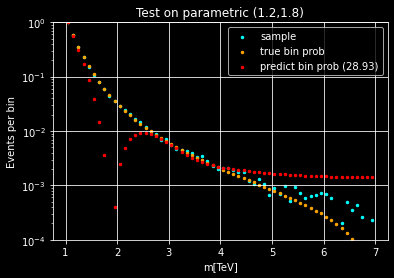

    Testing s2s_900_64_450_500_0.000000_exp...
900
    Test MSE: 31.766557018810204
    Test Sum: 1.0926045179367065


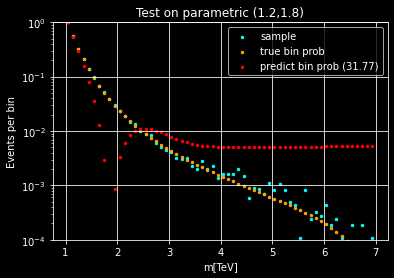

    Testing s2s_900_64_450_500_0.000000_exp...
900
    Test MSE: 26.221177968590084
    Test Sum: 1.0928386561572552


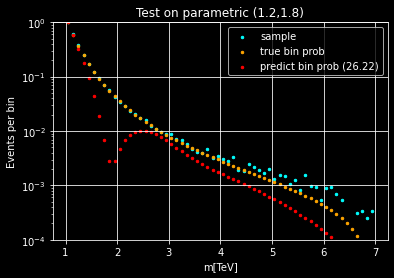

    Testing s2s_900_64_450_500_0.000000_exp...
900
    Test MSE: 20.690055742177073
    Test Sum: 1.0769178699702024


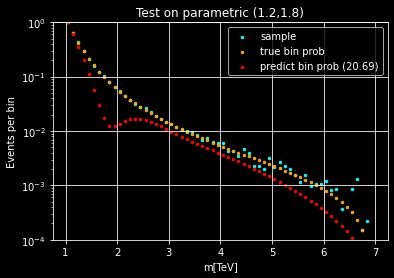

In [23]:
for ld in (32,64,256,400,500,600,700,800,900):
    train_test(sample_weight, latent_dim=ld, batch_size=64, patience=450, epochs=500, test_num=10, verbose=0)